## import necessary python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sb_utils import save_file

In [2]:
# Read csv file 
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
#data_rej = pd.read_csv("rejected_2007_to_2018Q4.csv")

In [5]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
# check first few rows of the data
df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

##### check potential lebels earlier so that it would be easier to drop the missing rows/columns

In [21]:
# Loan_Status is a potential label I want to predict
print(" The 'Loan_Status' variable is missing by: {:.4f}%".format(100 - df.loan_status.count()*100./max(df.count())))
print(" The 'Interest_Rate' variable is missing by: {:.4f}%".format(100 - df.int_rate.count()*100./max(df.count())))

 The 'Loan_Status' variable is missing by: 0.0015%
 The 'Interest_Rate' variable is missing by: 0.0015%


In [20]:
#sns.countplot(df.loan_status)
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

###### I have consider loan status and interest rate as potential labels and good news is that both of them have almost no Missing or Null values

## Understand the data
### Find missing values by columns and remove if more than 90% data is missing


In [23]:
print("Total shape of the data", df.shape)

Total shape of the data (2260701, 151)


In [24]:
missing = pd.concat([df.isnull().sum(), 100*df.isnull().mean()], axis=1)
missing.columns = ["count", "%"]
missing.sort_values(by = ["count"], ascending = False)

count           %
member_id                                   2260701  100.000000
orig_projected_additional_accrued_interest  2252050   99.617331
hardship_end_date                           2249784   99.517097
hardship_start_date                         2249784   99.517097
hardship_type                               2249784   99.517097
...                                             ...         ...
policy_code                                      33    0.001460
revol_bal                                        33    0.001460
fico_range_high                                  33    0.001460
fico_range_low                                   33    0.001460
id                                                0    0.000000

[151 rows x 2 columns]

In [25]:
## check the list of the columns having more than 90% data is missing and drop them
cnt = df.count()
col_del = cnt <= cnt.max()*0.9
col_del = cnt[col_del]
print("List of the columns to be dropped out", list(col_del.index))
df1 = df.drop(list(col_del.index), axis = 1)

List of the columns to be dropped out ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'p

In [26]:
print("New shape of the data", df1.shape)

New shape of the data (2260701, 92)


## FIND rows where null values are found and drop them

In [27]:
df2 = df1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df2.shape

(1852324, 92)

## There are no more null values in the dataset.
## Now explore the category of the data

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852324 entries, 0 to 2260697
Data columns (total 92 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          object 
 1   loan_amnt                   float64
 2   funded_amnt                 float64
 3   funded_amnt_inv             float64
 4   term                        object 
 5   int_rate                    float64
 6   installment                 float64
 7   grade                       object 
 8   sub_grade                   object 
 9   emp_title                   object 
 10  emp_length                  object 
 11  home_ownership              object 
 12  annual_inc                  float64
 13  verification_status         object 
 14  issue_d                     object 
 15  loan_status                 object 
 16  pymnt_plan                  object 
 17  url                         object 
 18  purpose                     object 
 19  title                

## check with object data types

In [14]:
## Group data by data types
df2.columns.to_series().groupby(df2.dtypes).groups

{float64: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_12

In [15]:
## print object data types columns
obj_list = list(df2.select_dtypes(include=['object']).columns)
obj_list

['id',
 'term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [16]:
## print nun unique values of all object types
cat_feat = df2.select_dtypes('object').columns.values
df2[cat_feat].nunique().sort_values(ascending = False)

id                      1852324
url                     1852324
emp_title                441721
title                     35171
zip_code                    950
earliest_cr_line            733
last_credit_pull_d           81
last_pymnt_d                 79
issue_d                      77
addr_state                   51
sub_grade                    35
purpose                      14
emp_length                   11
loan_status                   7
grade                         7
home_ownership                6
verification_status           3
term                          2
pymnt_plan                    2
initial_list_status           2
application_type              2
hardship_flag                 2
disbursement_method           2
debt_settlement_flag          2
dtype: int64

In [17]:
## drop coumns that have many uniques values AND not useful for the future uses
df3 = df2.drop(['id','url', 'emp_title', 'zip_code','earliest_cr_line','last_credit_pull_d', 'last_pymnt_d', 'issue_d'], axis=1)

In [18]:
df3.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     3600.0       3600.0           3600.0   36 months     13.99       123.03   
1    24700.0      24700.0          24700.0   36 months     11.99       820.28   
3    35000.0      35000.0          35000.0   60 months     14.85       829.90   
4    10400.0      10400.0          10400.0   60 months     22.45       289.91   
5    11950.0      11950.0          11950.0   36 months     13.44       405.18   

  grade sub_grade emp_length home_ownership  ...  percent_bc_gt_75  \
0     C        C4  10+ years       MORTGAGE  ...               0.0   
1     C        C1  10+ years       MORTGAGE  ...               7.7   
3     C        C5  10+ years       MORTGAGE  ...               0.0   
4     F        F1    3 years       MORTGAGE  ...              60.0   
5     C        C3    4 years           RENT  ...             100.0   

  pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex_mort  \
0                  0.0       0.0        178050.0            7746.0   
1                  0.0       0.0        314017.0           39475.0   
3                  0.0       0.0        381215.0           52226.0   
4                  0.0       0.0        439570.0           95768.0   
5                  0.0       0.0         16900.0           12798.0   

  total_bc_limit total_il_high_credit_limit  hardship_flag  \
0         2400.0                    13734.0              N   
1        79300.0                    24667.0              N   
3        62500.0                    18000.0              N   
4        20300.0                    88097.0              N   
5         9400.0                     4000.0              N   

   disbursement_method  debt_settlement_flag  
0                 Cash                     N  
1                 Cash                     N  
3                 Cash                     N  
4                 Cash                     N  
5                 Cash                     N  

[5 rows x 84 columns]

In [19]:
df3.purpose.value_counts()

debt_consolidation    1057139
credit_card            427135
home_improvement       122146
other                  109982
major_purchase          40064
medical                 21647
car                     18324
small_business          18042
vacation                12351
moving                  12266
house                   11356
renewable_energy         1088
wedding                   782
educational                 2
Name: purpose, dtype: int64

##  check with numeric data types

In [20]:
num_feat = df3.select_dtypes('float64').columns.values
df3[num_feat].nunique().sort_values(ascending = False)

total_pymnt         1365731
total_pymnt_inv     1141579
last_pymnt_amnt      623065
total_rec_int        592561
tot_hi_cred_lim      507952
                     ...   
acc_now_delinq            9
inq_last_6mths            9
num_tl_120dpd_2m          7
num_tl_30dpd              5
policy_code               1
Length: 68, dtype: int64

In [21]:
df3[num_feat].describe()

loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count  1.852324e+06  1.852324e+06     1.852324e+06  1.852324e+06   
mean   1.542493e+04  1.542492e+04     1.541973e+04  1.303282e+01   
std    9.247357e+03  9.247358e+03     9.245230e+03  4.850342e+00   
min    1.000000e+03  1.000000e+03     7.250000e+02  5.310000e+00   
25%    8.000000e+03  8.000000e+03     8.000000e+03  9.440000e+00   
50%    1.387500e+04  1.387500e+04     1.382500e+04  1.262000e+01   
75%    2.000000e+04  2.000000e+04     2.000000e+04  1.580000e+01   
max    4.000000e+04  4.000000e+04     4.000000e+04  3.099000e+01   

        installment    annual_inc           dti   delinq_2yrs  fico_range_low  \
count  1.852324e+06  1.852324e+06  1.852324e+06  1.852324e+06    1.852324e+06   
mean   4.551503e+02  8.062924e+04  1.895265e+01  3.127865e-01    6.987327e+02   
std    2.682615e+02  1.115967e+05  1.155800e+01  8.751482e-01    3.281786e+01   
min    4.930000e+00  0.000000e+00 -1.000000e+00  0.000000e+00    6.600000e+02   
25%    2.600900e+02  4.990000e+04  1.229000e+01  0.000000e+00    6.750000e+02   
50%    3.881100e+02  6.800000e+04  1.808000e+01  0.000000e+00    6.900000e+02   
75%    6.053400e+02  9.548425e+04  2.464000e+01  0.000000e+00    7.150000e+02   
max    1.719830e+03  1.100000e+08  9.990000e+02  5.800000e+01    8.450000e+02   

       fico_range_high  ...  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
count     1.852324e+06  ...        1.852324e+06        1.852324e+06   
mean      7.027328e+02  ...        7.873083e-02        2.088916e+00   
std       3.281860e+01  ...        4.819732e-01        1.824942e+00   
min       6.640000e+02  ...        0.000000e+00        0.000000e+00   
25%       6.790000e+02  ...        0.000000e+00        1.000000e+00   
50%       6.940000e+02  ...        0.000000e+00        2.000000e+00   
75%       7.190000e+02  ...        0.000000e+00        3.000000e+00   
max       8.500000e+02  ...        5.800000e+01        3.100000e+01   

       pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies     tax_liens  \
count    1.852324e+06      1.852324e+06          1.852324e+06  1.852324e+06   
mean     9.422728e+01      4.216253e+01          1.236155e-01  4.832956e-02   
std      8.885309e+00      3.608518e+01          3.611214e-01  3.869295e-01   
min      0.000000e+00      0.000000e+00          0.000000e+00  0.000000e+00   
25%      9.170000e+01      0.000000e+00          0.000000e+00  0.000000e+00   
50%      1.000000e+02      3.750000e+01          0.000000e+00  0.000000e+00   
75%      1.000000e+02      7.000000e+01          0.000000e+00  0.000000e+00   
max      1.000000e+02      1.000000e+02          1.200000e+01  8.500000e+01   

       tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
count     1.852324e+06       1.852324e+06    1.852324e+06   
mean      1.846144e+05       5.383278e+04    2.368598e+04   
std       1.812808e+05       5.093052e+04    2.289159e+04   
min       2.000000e+02       0.000000e+00    1.000000e+02   
25%       5.512500e+04       2.320200e+04    8.700000e+03   
50%       1.228115e+05       4.026500e+04    1.680000e+04   
75%       2.658360e+05       6.735300e+04    3.100000e+04   
max       9.999999e+06       3.408095e+06    1.105500e+06   

       total_il_high_credit_limit  
count                1.852324e+06  
mean                 4.665703e+04  
std                  4.572662e+04  
min                  0.000000e+00  
25%                  1.791300e+04  
50%                  3.520600e+04  
75%                  6.179800e+04  
max                  2.118996e+06  

[8 rows x 68 columns]

In [22]:
df3.num_tl_30dpd.value_counts()

0.0    1847279
1.0       4801
2.0        213
3.0         24
4.0          7
Name: num_tl_30dpd, dtype: int64

### Lets check our target variable in more details and remove the unnecessary values

###### Since I am interested to predict either the loan was paid off or not so, I want to keep only "Fully Paid" & "Charged Off"
remove the others

In [53]:
df3['loan_status'].value_counts(dropna=False)

Fully Paid            880570
Current               734292
Charged Off           210041
Late (31-120 days)     17051
In Grace Period         6949
Late (16-30 days)       3391
Default                   30
Name: loan_status, dtype: int64

In [79]:
df4 = df3.loc[df3['loan_status'].isin(['Fully Paid', 'Charged Off'])]

### Lets check outlier by plotting boxplots of few ineresting variables



In [94]:
df44 = df3[num_feat]   ## contains only floating numbers

In [95]:
df4.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     3600.0       3600.0           3600.0   36 months     13.99       123.03   
1    24700.0      24700.0          24700.0   36 months     11.99       820.28   
4    10400.0      10400.0          10400.0   60 months     22.45       289.91   
5    11950.0      11950.0          11950.0   36 months     13.44       405.18   
6    20000.0      20000.0          20000.0   36 months      9.17       637.58   

  grade sub_grade emp_length home_ownership  ...  percent_bc_gt_75  \
0     C        C4  10+ years       MORTGAGE  ...               0.0   
1     C        C1  10+ years       MORTGAGE  ...               7.7   
4     F        F1    3 years       MORTGAGE  ...              60.0   
5     C        C3    4 years           RENT  ...             100.0   
6     B        B2  10+ years       MORTGAGE  ...             100.0   

  pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex_mort  \
0                  0.0       0.0        178050.0            7746.0   
1                  0.0       0.0        314017.0           39475.0   
4                  0.0       0.0        439570.0           95768.0   
5                  0.0       0.0         16900.0           12798.0   
6                  0.0       0.0        388852.0          116762.0   

  total_bc_limit total_il_high_credit_limit  hardship_flag  \
0         2400.0                    13734.0              N   
1        79300.0                    24667.0              N   
4        20300.0                    88097.0              N   
5         9400.0                     4000.0              N   
6        31500.0                    46452.0              N   

   disbursement_method  debt_settlement_flag  
0                 Cash                     N  
1                 Cash                     N  
4                 Cash                     N  
5                 Cash                     N  
6                 Cash                     N  

[5 rows x 84 columns]

<AxesSubplot:xlabel='grade', ylabel='loan_amnt'>

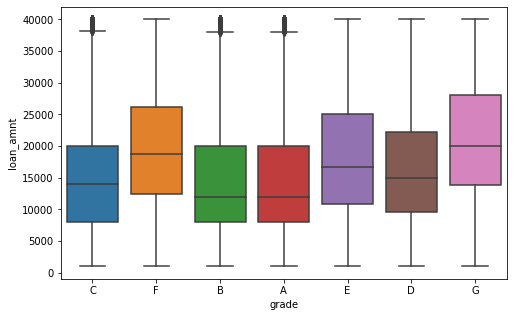

In [87]:
plt.figure(figsize = (8,5))
sns.boxplot(y="loan_amnt", x="grade", data=df3)

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

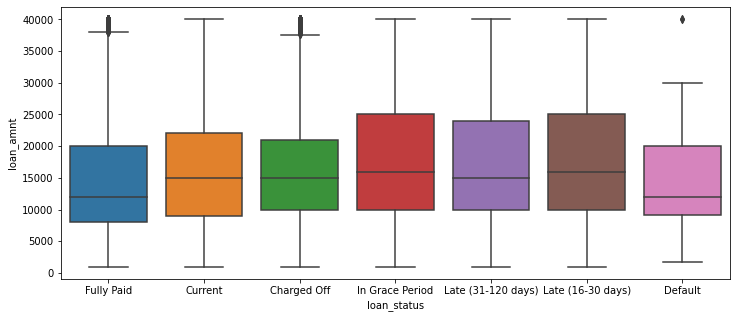

In [86]:
plt.figure(figsize = (12,5))
sns.boxplot(y="loan_amnt", x="loan_status", data=df3)

<AxesSubplot:xlabel='loan_status', ylabel='int_rate'>

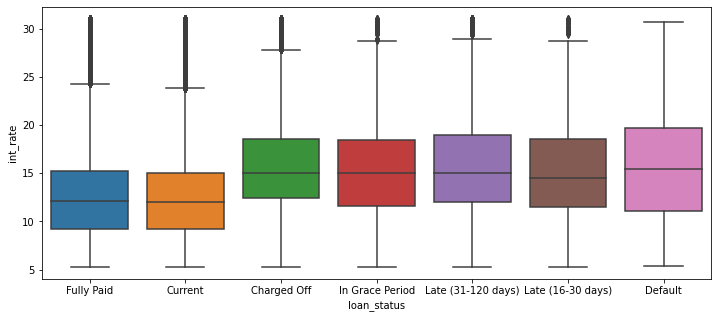

In [85]:
plt.figure(figsize = (12,5))
sns.boxplot(y="int_rate", x="loan_status", data=df3)

<AxesSubplot:xlabel='emp_length', ylabel='int_rate'>

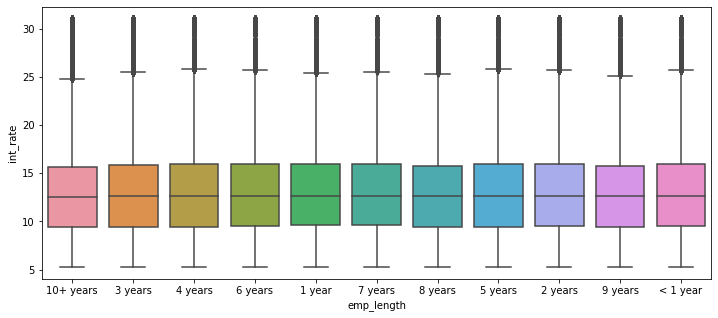

In [76]:
plt.figure(figsize = (12,5))
sns.boxplot(x="emp_length", y = "int_rate", data=df3)

In [98]:
corr = df44.iloc[:, 0:50].corr()

<AxesSubplot:>

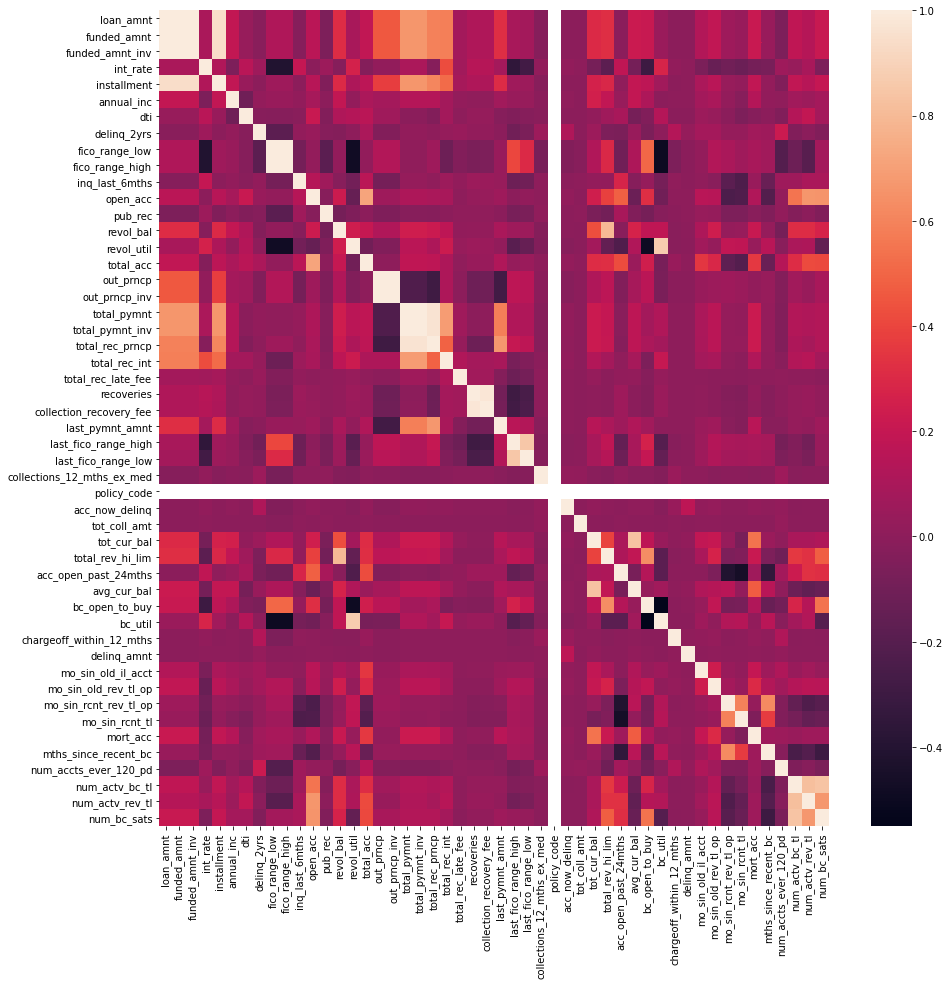

In [99]:
plt.figure(figsize=(15,15))
sns.heatmap(corr)

## Seems like the data has no missing values and good to go for next steps

In [31]:
## save data 
#data_dir = "./"
#save_file(df3, "LendingClub_cleaned.csv", data_dir)